In [1]:
import os
from pyhdf.HDF import *
from pyhdf.VS import *
from pyhdf.SD import SD, SDC
import numpy as np
from datetime import datetime, timedelta, timezone
import xarray as xa
import matplotlib.pyplot as plt
from utils import setup_cmap
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
os.environ["TZ"] = "UTC"

In [17]:
# Setup plotting range
infile = '/glade/work/swei/data/RawOBS/CALIPSO/CAL_LID_L2_05kmAPro-Standard-V4-20.2019-07-22T03-45-56ZN.hdf'

x_start = 0
x_stop = 1000

In [3]:
def calipso_time2dt(time):
    dtarr = [datetime.strptime(str(t)[:6], '%y%m%d') for t in time]
    delta = [timedelta(frac) for frac in np.mod(time, 1)]
    outarr = [(dt + dl).replace(tzinfo=timezone.utc) for dt, dl in zip(dtarr, delta)]
    return outarr


def avg_horz_data(data, N):
    if len(data.shape)==2:
        nAlts = data.shape[1]
        nProfiles = data.shape[0]
        nOutProfiles = np.floor(nProfiles/N)
        out = np.zeros((int(nOutProfiles), int(nAlts)))
        for i in range(0, int(nOutProfiles) - 1):
            out[i, :] = np.nanmean(data[i*N:(i+1)*N, :], axis=0)
    elif len(data.shape)==1:
        nProfiles = data.shape[0]
        nOutProfiles = int(np.floor(nProfiles/N))
        out = np.zeros((nOutProfiles))
        for i in range(0, nOutProfiles - 1):
            out[i] = np.nanmean(data[i*N:(i+1)*N], axis=0)
    return out


def uniform_alt_2(max_altitude, old_altitude_array):
    # https://github.com/NASA-DEVELOP/VOCAL/blob/15182377cd9d7de1c03b123e3bbe15b0e959ac80/calipso/plot/uniform_alt_2.py
    D_ALT = 0.03  # spacing is 30 m
    # Altitude indices for high res altitude region (region 2):
    # 288:576
    MID_RES_TOP = 288
    MID_RES_BOT = 576
    alt2 = old_altitude_array[MID_RES_TOP:MID_RES_BOT]
    new_num_bins = int(np.ceil((max_altitude-alt2[0])/D_ALT))
    new_length = int(new_num_bins + len(alt2))
    new_alt = np.zeros(int(new_length))
    new_alt[int(new_num_bins):int(new_length)] = alt2
    upper_altitudes =  (np.arange(new_num_bins) + 1.)*D_ALT
    new_alt[:int(new_num_bins)] = new_alt[int(new_num_bins)] + upper_altitudes[::-1]
    return new_alt


def regrid_lidar(alt, inMatrix, new_alt, method = 'linear'):
    # https://github.com/NASA-DEVELOP/VOCAL/blob/15182377cd9d7de1c03b123e3bbe15b0e959ac80/calipso/plot/regrid_lidar.py
    interpFunc = interpolate.interp1d(alt[::-1], inMatrix[::-1,:], kind=method, 
                                      axis=0, bounds_error=False)
    return interpFunc(new_alt)

In [4]:
# New coloar bar for CALIOP: https://ntrs.nasa.gov/api/citations/20250001533/downloads/Tackett_CCSTM_2025_Ver02.pdf
caliop_bound_flt_lst = [
    9.0e-5,    1.0e-4,    2.0e-4,    3.0e-4,
    4.0e-4,    5.0e-4,    6.0e-4,    7.0e-4,
    8.0e-4,    9.0e-4,    1.0e-3,    1.5e-3,
    2.0e-3,    2.5e-3,    3.0e-3,    3.5e-3,
    4.0e-3,    4.5e-3,    5.0e-3,    5.5e-3,
    6.0e-3,    6.5e-3,    7.0e-3,    7.5e-3,
    8.0e-3,    1.0e-2,    2.0e-2,    3.0e-2,
    4.0e-2,    5.0e-2,    6.0e-2,    7.0e-2,
    8.0e-2,    9.0e-2,    1.0e-1
]
color_idx = np.arange(2, 35)
color_map = setup_cmap('caliop_legacy', color_idx)

In [5]:
caliop_ref_time = datetime(1993, 1, 1, 0, 0, 0)

In [14]:
loc_slice = slice(x_start, x_stop)

In [18]:
hdf = HDF(infile)
vs = hdf.vstart()
metaid = vs.find('metadata')
vd = vs.attach(metaid)
vd.setfields('Lidar_Data_Altitudes')
alt = np.array(vd.read()[0][0])
vd.detach()
vs.end()

In [19]:
# Level 1 backscatter
sd = SD(infile, SDC.READ)

In [20]:
lats = sd.select('Latitude').get()[loc_slice, 0]
lons = sd.select('Longitude').get()[loc_slice, 0]
proftime = sd.select('Profile_UTC_Time').get()[loc_slice, 0]
obs_time = np.array([pt.timestamp() for pt in calipso_time2dt(proftime)], dtype=np.int64)

In [21]:
ext1 = sd.select('Extinction_Coefficient_532').get()[loc_slice, :]
ext2 = sd.select('Extinction_Coefficient_1064').get()[loc_slice, :]

In [22]:
mask1 = (ext1 == -9999.)|((ext1 < 0.0)|(ext1 > 1.25)) 
mask2 = (ext2 == -9999.)|((ext2 < 0.0)|(ext2 > 1.0))

In [24]:
ext1 = np.where(mask1, np.nan, ext1)
ext2 = np.where(mask2, np.nan, ext2)

In [32]:
data_dict = {
    'Ext532': (['Location', 'Height'], ext1),
    'Ext1064': (['Location', 'Height'], ext2),
    'dateTime': (['Location'], obs_time),
    'lat': (['Location'], lats),
    'lon': (['Location'], lons),
}
coord_dict = {
    'Height': alt,
    'Location': np.arange(obs_time.size),
}

In [33]:
ext_ds = xa.Dataset(data_dict, coords=coord_dict)

In [34]:
plot_ds = ext_ds.sel(Height=slice(30000, -200))

In [30]:
print(plot_ds.dateTime.data[0], plot_ds.dateTime.data[-1])

1563767152 1563767895


In [31]:
xvals = []
xstrs = []
for i in np.round(np.linspace(plot_ds.Location.data[0], plot_ds.Location.data[-1], 10, dtype=np.int32)):
    xvals.append(i + plot_ds.Location.data[0])
    if i == 0:
        xstrs.append('Lat: %.2f \n Lon: %.2f' % (plot_ds.lat[i],plot_ds.lon[i]))
    else:
        xstrs.append('%.2f \n %.2f' % (plot_ds.lat[i],plot_ds.lon[i]))

[Text(0, 0, 'Lat: 58.29 \n Lon: -15.49'),
 Text(111, 0, '53.43 \n -18.11'),
 Text(222, 0, '48.53 \n -20.25'),
 Text(333, 0, '43.60 \n -22.08'),
 Text(444, 0, '38.65 \n -23.69'),
 Text(555, 0, '33.69 \n -25.13'),
 Text(666, 0, '28.71 \n -26.46'),
 Text(777, 0, '23.72 \n -27.69'),
 Text(888, 0, '18.72 \n -28.86'),
 Text(999, 0, '13.72 \n -29.98')]

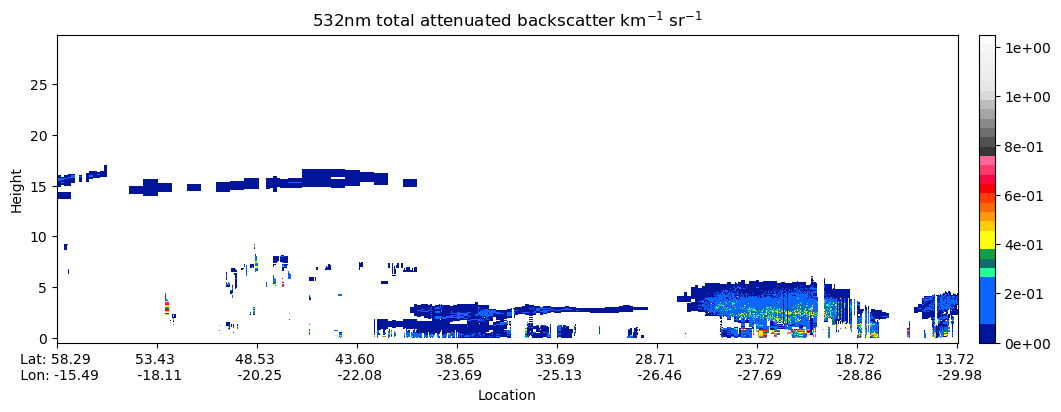

In [35]:
p = plot_ds.Ext532.plot(
    x='Location',
    cmap=color_map,
    vmin=0.0,
    vmax=1.25,
    size=4,
    aspect=3.5,
    add_colorbar=True,
    cbar_kwargs={
        'format': "%.e",
        'label': None,
        'pad': 0.02
    },
)
p.axes.set_title(r'532nm total attenuated backscatter km$^{-1}$ sr$^{-1}$')
p.axes.set_xticks(xvals)
p.axes.set_xticklabels(xstrs)

In [50]:
p.figure.savefig('caliop_l1b_hofx.png', dpi=300)

In [51]:
ncfile = '/glade/derecho/scratch/swei/jpss-simcaliop-out2/AOD/aod.2019072203.nc'
ds = xa.open_dataset(ncfile)

In [62]:
proj = ccrs.PlateCarree()
c_lon = plot_ds.lon.mean().data
c_lat = plot_ds.lat.mean().data

In [70]:
plot_ds.lon.data

array([-15.48911 , -15.490871, -15.492632, ..., -30.647308, -30.647976,
       -30.64864 ], dtype=float32)

In [55]:
colors = ["white", "tab:orange", "black"]
n_bins = 100
cmap = LinearSegmentedColormap.from_list('here', colors, N=n_bins)

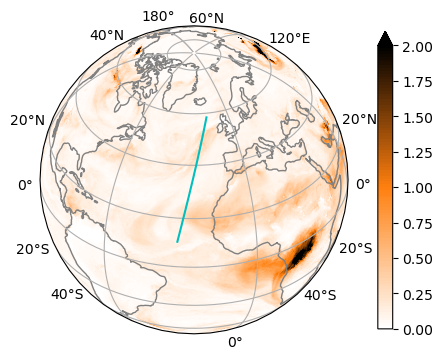

In [95]:
p = ds.aod.sel(nt=0).plot(
    vmin=0,
    vmax=2,
    size=4,
    aspect=1.6,
    add_colorbar=True,
    subplot_kws=dict(
        projection=ccrs.Orthographic(c_lon, c_lat),
    ),
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    cbar_kwargs=dict(
        label=None,
        pad=0.06,
        fraction=0.03,
    ),
)
p.axes.gridlines(draw_labels=True)
p.axes.coastlines(color='grey')
plt.plot(plot_ds.lon.data[::2000], plot_ds.lat.data[::2000], 'c', ls='-', lw=1.5, marker='', zorder=5, transform=ccrs.PlateCarree())

In [96]:
p.figure.savefig('caliop_path.png', dpi=300)